# SEIR Model for COVID-19 Forecasting

In [98]:
%load_ext lab_black

# Data manipulation
import numpy as np
import pandas as pd

pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 500

# Data viz
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

sns.set(style="darkgrid", rc={"figure.figsize": (11.7, 8.27)})

# Modeling
from bayes_opt import BayesianOptimization
from scipy.optimize import minimize

# Other
import copy
from datetime import datetime, timedelta
import os
import random
import sys
from typing import List, Tuple

# Custom module
module_path = os.path.abspath(os.path.join("../src"))
if module_path not in sys.path:
    sys.path.append(module_path)

from fixed_params import *
from learn_simulation import *
from region_model import RegionModel
from simulation import run, predict
from utils import str_to_date, remove_space_region, plot_predictions

# Reload imported code
%reload_ext autoreload
%autoreload 2

# Print all output
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# Set seeds for reproducibility
rand_seed = 2
np.random.seed(rand_seed)
random.seed(rand_seed)

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


## Purpose

The goal is to produce accurate forecasts of COVID-19 deaths and infections in Canada. One of the models we'll be focusing on is an SEIR model using a simulator based off of https://covid19-projections.com/model-details/.  

## Load Data and EDA

For the data we'll only be using mortality data as cases data can be innacurate and add noise to the model. The dataset can be found here https://github.com/ishaberry/Covid19Canada.

In [76]:
# Read in data
mortality_prov = pd.read_csv("../data/timeseries_prov/mortality_timeseries_prov.csv")
active_cases_prov = pd.read_csv("../data/timeseries_prov/active_timeseries_prov.csv")

# Simple preprocessing
format = "%d-%m-%Y"
mortality_prov = mortality_prov.assign(
    date_death_report=lambda x: pd.to_datetime(
        x["date_death_report"], format=format
    ).dt.date
)

active_cases_prov = active_cases_prov.assign(
    date_active=lambda x: pd.to_datetime(x["date_active"], format=format).dt.date
).assign(cumulative_removed=lambda x: x["cumulative_cases"] + x["cumulative_recovered"])

# Filter for Ontario
mortality_ontario = mortality_prov.query('province == "Ontario"')
active_cases_ontario = active_cases_prov.query('province == "Ontario"')

# Get first and last day of death reports
mortality_start_date = mortality_prov["date_death_report"].min()
mortality_end_date = mortality_prov["date_death_report"].max()

mortality_prov.head(10)

,province,date_death_report,deaths,cumulative_deaths
0,Alberta,2020-03-08,0,0
1,Alberta,2020-03-09,0,0
2,Alberta,2020-03-10,0,0
3,Alberta,2020-03-11,0,0
4,Alberta,2020-03-12,0,0
5,Alberta,2020-03-13,0,0
6,Alberta,2020-03-14,0,0
7,Alberta,2020-03-15,0,0
8,Alberta,2020-03-16,0,0
9,Alberta,2020-03-17,0,0


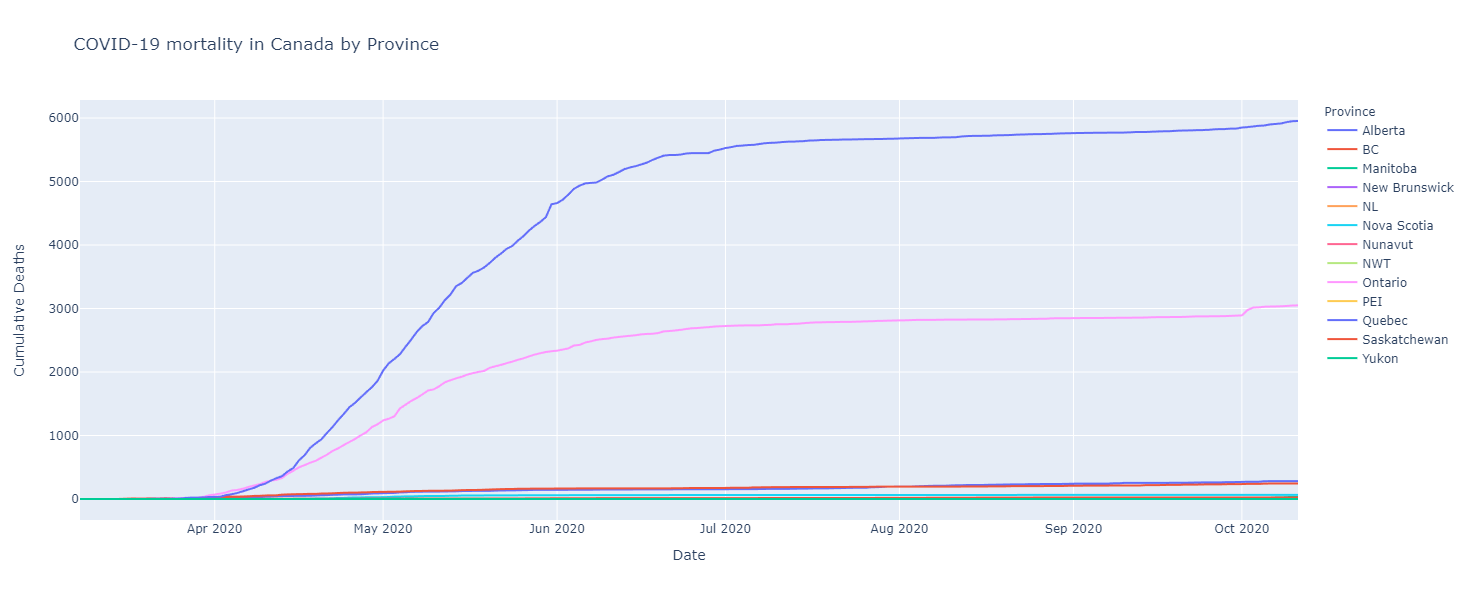

In [77]:
fig = px.line(
    mortality_prov,
    x="date_death_report",
    y="cumulative_deaths",
    color="province",
    title="COVID-19 mortality in Canada by Province",
    labels=dict(
        date_death_report="Date",
        cumulative_deaths="Cumulative Deaths",
        province="Province",
    ),
    height=600,
)
fig.show()

### Comments

- From the mortalities plot above it seems like Quebec and Ontario make up the majority of covid mortalities in Canada. They greatly increase at the start and then slow down and are currently starting to level out
- The other provinces have much lower growth in deaths. Zooming in we see a mostly linear pattern
- All the provinces have their date death reports on the same day March 8, 2020

## SEIR Parameter Estimation

First we would want to replace the simple grid search layer in the original model with more sophisticated optimization methods. The parameters we'll be tuning are:

- Mortality rate
- Initial $R_0$
- Lockdown $R_0$
- Imports of positive cases per day

To handle overfitting we'll be applying cross-validation. Since we are dealing with time series we will split our data a bit differently. The data will be split into folds in order from 1 to k and for each $i$ from 1 to k we will use train the model on the first 1 to i folds and validate on the remaining folds. For our loss function we'll be using root mean squared error (RMSE) on the cumulative sum of deaths.

In [99]:
# Set argument values
skip_hospitalizations = None
quarantine_perc = 0
quarantine_effectiveness = -1
best_params_type = "mean"
country = "Canada"
region = "ALL"
subregion = "Ontario"
best_params_dir = "../best_params/latest"

# Set start and end dates
simulation_start_date = mortality_start_date - timedelta(days=DAYS_BEFORE_DEATH)
simulation_create_date = datetime.date.today()
simulation_end_date = datetime.date(year=2020, month=11, day=1)

# Load parameters from file. This contains both fixed and variable parameters. We will not use the given variable parameters however
region_params, params_dict = load_best_params_province("Ontario")

# Create base region model
region_model = RegionModel(
    country,
    region,
    subregion,
    simulation_start_date,
    simulation_create_date,
    simulation_end_date,
    region_params,
    compute_hospitalizations=(not skip_hospitalizations),
)

Loading params file: ../best_params/latest/subregion\Canada_Ontario.json


In [81]:
def loss(
    variable_params: Tuple,
    params: dict,
    region_model: RegionModel,
    mortality_data: pd.DataFrame,
) -> float:
    """
    Helper function for calculting root mean squared error for SEIR model.
    """
    # Initialize parameters for region model
    (
        params["INITIAL_R_0"],
        params["LOCKDOWN_R_0"],
        params["MORTALITY_RATE"],
        params["DAILY_IMPORTS"],
    ) = variable_params
    params_tups = tuple(params_dict.items())
    region_model_copy = copy.deepcopy(region_model)
    region_model_copy.init_params(params_tups)

    # Run SEIR simulation
    mortality_pred = predict(region_model_copy, mortality_data)

    # Calculate rmse. Use only projections for known dates and not future forecasts
    mortality_pred = mortality_pred.query("cumulative_deaths == cumulative_deaths")
    deaths_true = mortality_pred["cumulative_deaths"]
    deaths_pred = mortality_pred["cumulative_deaths_pred"]

    rmse = np.sqrt(np.mean((deaths_true - deaths_pred) ** 2))

    return rmse

### L-BFGS-B Optimization

Bound constrained minimization implemented in scipy https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

In [82]:
%%time

# Estimate optimal parameters using L-BFGS-B method in scipy
optimal = minimize(
    loss,
    x0=[1, 1, 0.01, 100],
    args=(params_dict, region_model, mortality_ontario),
    method="L-BFGS-B",
    bounds=[(1e-4, 10), (1e-4, 10), (1e-4, 0.2 - 1e-6), (0, 1000)],
)

Wall time: 11.2 s


In [83]:
# Initialize parameters for region_model using estimated params
(
    params_dict["INITIAL_R_0"],
    params_dict["LOCKDOWN_R_0"],
    params_dict["MORTALITY_RATE"],
    params_dict["DAILY_IMPORTS"],
) = optimal.x
params_tups = tuple(params_dict.items())
region_model.init_params(params_tups)

# Run simulation and calculate loss
mortality_pred = predict(region_model, mortality_ontario)
rmse = loss(optimal.x, params_dict, region_model, mortality_ontario)
print(f"rmse: {rmse}")

rmse: 34.08331752370795


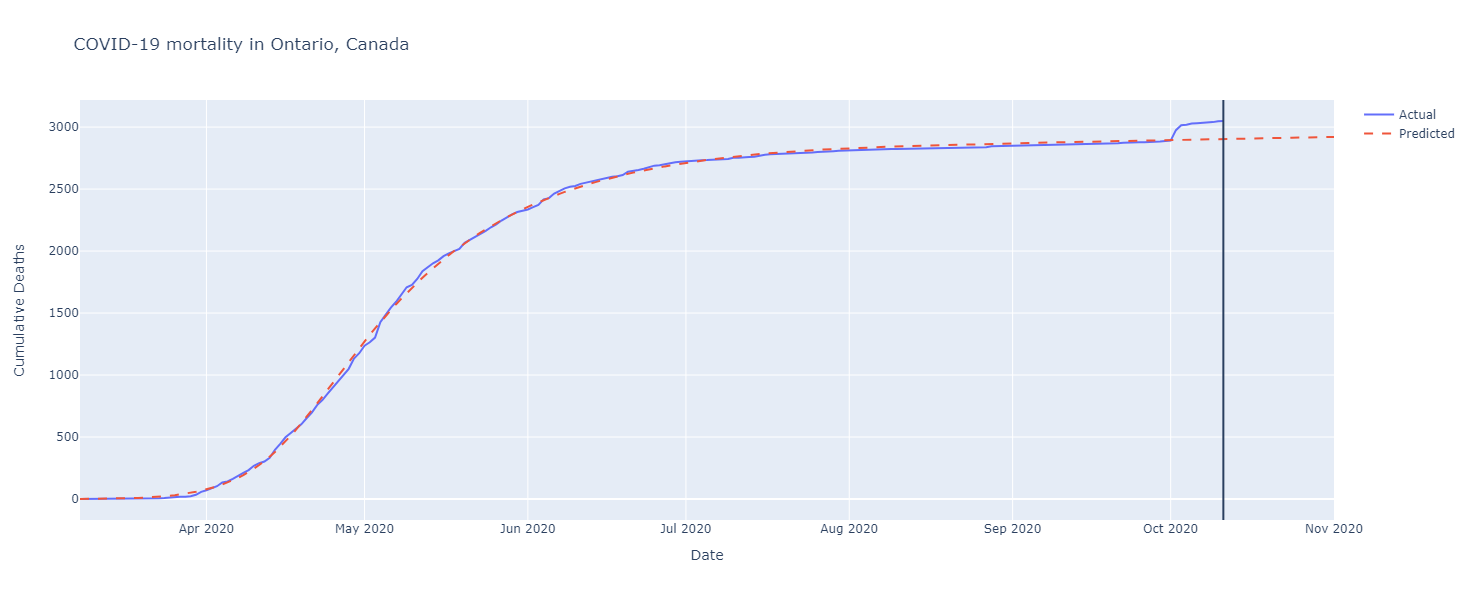

In [84]:
# Plot results
plot_predictions(mortality_pred, title="COVID-19 mortality in Ontario, Canada")

### Bayesian Optimization

In [85]:
%%time

# Setup parameters
pbounds = {
    "initial_r_0": (1e-4, 10),
    "lockdown_r_0": (1e-4, 10),
    "mortality_rate": (1e-4, 0.2 - 1e-6),
    "daily_imports": (0, 1000),
}

optimizer = BayesianOptimization(
    f=lambda initial_r_0, lockdown_r_0, mortality_rate, daily_imports: -loss(
        (initial_r_0, lockdown_r_0, mortality_rate, daily_imports),
        params_dict,
        region_model,
        mortality_ontario,
    ),
    pbounds=pbounds,
    verbose=1,
)

# # Some initial guess
# optimizer.probe(
#     params={
#         "initial_r_0": 2,
#         "lockdown_r_0": 1,
#         "mortality_rate": 0.01,
#         "daily_imports": 200,
#     },
#     lazy=True,
# )

# Run optimization
optimizer.maximize(
    init_points=100,
    n_iter=100,
)

|   iter    |  target   | daily_... | initia... | lockdo... | mortal... |
-------------------------------------------------------------------------
|  2        | -4.632e+0 |  613.4    |  3.71     |  9.083    |  0.06826  |
|  5        | -2.082e+0 |  571.1    |  0.01456  |  0.4922   |  0.1783   |
|  50       | -1.857e+0 |  781.9    |  0.7437   |  0.4572   |  0.007317 |
|  84       | -509.2    |  454.2    |  0.9851   |  0.1259   |  0.05549  |
|  136      | -438.7    |  452.6    |  1.337    |  0.03014  |  0.02255  |
|  156      | -425.1    |  572.8    |  0.7638   |  0.1602   |  0.05431  |
Wall time: 1min 8s


In [86]:
# Initialize parameplot_predictionsfor region_model using estimated params
max_params = optimizer.max["params"]
params_dict["INITIAL_R_0"] = max_params["initial_r_0"]
params_dict["LOCKDOWN_R_0"] = max_params["lockdown_r_0"]
params_dict["MORTALITY_RATE"] = max_params["mortality_rate"]
params_dict["DAILY_IMPORTS"] = max_params["daily_imports"]

params_tups = tuple(params_dict.items())
region_model.init_params(params_tups)

# Run simulation and calculate loss
mortality_pred = predict(region_model, mortality_ontario)
rmse = -optimizer.max["target"]
print(f"rmse: {rmse}")

rmse: 425.0934346547462


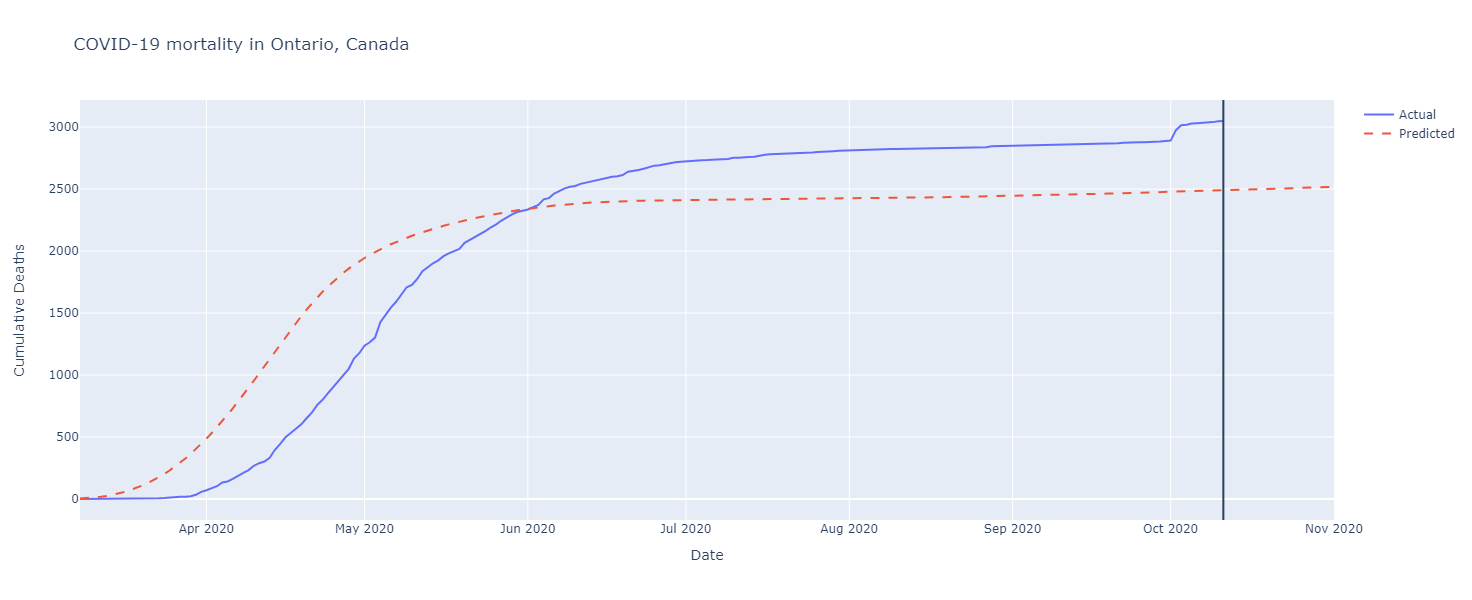

In [87]:
# Plot results
plot_predictions(mortality_pred, title="COVID-19 mortality in Ontario, Canada")

### Grid search

In [ ]:

real_death = mortality_ontario['deaths'].tolist()
real_death_all = mortality_ontario['cumulative_deaths'].tolist()
real_date = mortality_end_date

In [34]:
# Set simulation parameters

params_tups = tuple(params_dict.items())
region_model.init_params(params_tups)
dates, infections, hospitalizations, deaths = run(region_model)

deaths_total = deaths.cumsum()
ind = np.where(dates == real_date)[0].item()
deaths_proj = deaths_total[: ind + 1]

if len(deaths_total[: ind + 1]) >= len(real_death_all):
    pad = len(deaths_proj) - len(real_death_all)
    real_death_all = np.array([0] * pad + real_death_all)

if len(real_death_all) > len(deaths_total[: ind + 1]):
    real_death_all = np.array(real_death_all)
    pad = len(real_death_all) - len(deaths_total[: ind + 1])
    deaths_proj = np.zeros(pad).extend(deaths_proj)
days = len(real_death_all)

best_error = 1 / days * sum((real_death_all - deaths_proj) ** 2)
MR = params_dict["MORTALITY_RATE"]  # =0.013
IR = params_dict["INITIAL_R_0"]  # =1.79

LR = params_dict["LOCKDOWN_R_0"]  # =0.76
DI = params_dict["DAILY_IMPORTS"]  # =160

In [ ]:
for params_dict["INITIAL_R_0"] in np.linspace(IR * 0.7, IR):
    for params_dict["LOCKDOWN_R_0"] in np.linspace(LR * 0.95, LR * 1.05, 20):
        for params_dict["DAILY_IMPORTS"] in np.linspace(DI, DI * 1.35):
            for params_dict["MORTALITY_RATE"] in np.linspace(
                MR * 1.5, MR * 2.5, 20
            ):
                params_tups = tuple(params_dict.items())
                region_model.init_params(params_tups)
                dates, infections, hospitalizations, deaths = run(region_model)
                deaths_total = deaths.cumsum()
                deaths_proj = deaths_total[: ind + 1]

                if len(real_death_all) > len(deaths_total[: ind + 1]):
                    real_death_all = np.array(real_death_all)
                    pad = len(real_death_all) - len(deaths_total[: ind + 1])
                    deaths_proj = np.zeros(pad).extend(deaths_total[: ind + 1])

                error = 1 / days * sum((real_death_all - deaths_proj) ** 2)
                if error <= best_error:
                    best_error = error
                    inf_proj, hosp_proj, death_proj = (
                        infections,
                        hospitalizations,
                        deaths,
                    )
                    best_parameters = {
                        "INITIAL_R_0": params_dict["INITIAL_R_0"],
                        "LOCKDOWN_R_0": params_dict["LOCKDOWN_R_0"],
                        "DAILY_IMPORTS": params_dict["DAILY_IMPORTS"],
                        "MORTALITY_RATE": params_dict["MORTALITY_RATE"],
                    }
                    print("Finding new optimum with error:", best_error)

print(best_parameters)

### Comments

## Confidence Intervals with Monte Carlo Method